# ***Deep Learning Techniques for Visual Place Recognition***
## ***Index***
**1. [Preliminary Steps](#preliminary-steps)**

**2. [Baseline Experiments and Dataset Visualization](##-Baseline-Experiments-and-Dataset-Visualization)**

> **2.1 [Training and testing with the baseline model](##-Training-and-testing-with-the-baseline-model)**


>  **2.2 [Understanding the Datasets](##-Understanding-the-Datasets)**


**3. [“Smart” Data Augmentation for Night Domain](##-“Smart”-Data-Augmentation-for-Night-Domain)**

**4. [Synthetic Images as Data Augmentation](##-Synthetic-Images-as-Data-Augmentation)**

> **4.1 [Testing various UNIT transformations](##-Testing-various-UNIT-transformations)**


> **4.2 [Comparing results obtained with UNIT PT models](##-Comparing-results-obtained-with-UNIT-PT-models)**


> **4.3 [Creation of pitts30k_night dataset](##-Creation-of-pitts30k_night-dataset)**

> **4.4 [Creation of pitts30k_dn dataset](##-Creation-of-pitts30k_dn-dataset)**

**5. [Data Augmentation for Occlusion and Perspective Changes](##-Data-Augmentation-for-Occlusion-and-Perspective-Changes)**

**6. [Ensembles](##-Ensembles)**

**7. [Multi-scale Testing](##-Multi-scale-Testing)**


> **7.1 [Concatenation](#-Concatenation)**

> **7.2 [Average](#-Average)**



#***1. Preliminary Steps***

In this section we show how to set the environment to work on the baseline code; we clone the benchmark folder and install the needed requirements.

WARNING: to not run into trouble or unexpected errors while running it is adviced to download the entire folder from the github, load it on your google drive and use it as it is without changing the paths.

In [ ]:
!git clone https://github.com/gmberton/deep-visual-geo-localization-benchmark
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
%cd /content/drive/MyDrive/code/benchmarking_vg/model
!python __init__.py
import os
os.environ['DATASETS_FOLDER'] = "/content/drive/MyDrive/code/datasets_vg/datasets"
%cd ..
!pip install -r requirements.txt

#***2. Baseline Experiments and Dataset Visualization***

## 2.1 Training and testing with the baseline model

In order to better understand the original work we perform some experiments and train the original model with 5 epochs. The training is performed using pitts30k first with NetVLAD (default aggregation layer) and then with GeM.

### Training and testing using NetVLAD

In [ ]:
!python3 train.py --dataset_name=pitts30k --epochs_num=5 --aggregation=netvlad

The training performed in the cell above creates a log folder in which the best model is saved. The folder is in the following format: *YYYY-MM-DD_hh-mm-ss*.
Using the best_model.pth file in the log folder we perform the test on every available dataset.

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=pitts30k

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=sf-xs

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo-night

###Training and testing using GeM

Everything is performed exacltly the same as for NetVLAD but in this case we need to specify that the aggregation layer to use is GeM. 

In [ ]:
!python3 train.py --dataset_name=pitts30k --epochs_num=5 --aggregation=gem

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=pitts30k --aggregation=gem

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=sf-xs --aggregation=gem

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo --aggregation=gem

In [ ]:
!python3 eval.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo-night --aggregation=gem

## 2.2 Understanding the datasets

In order to better understand how the datasets are built we create some plots that show us how the images are distributed in a certain georaphical region. In particular we are interested in understanding how close to each other these geo-tagged images are and how dense they are. 
We create a function to help us extract the coordinates of every image in the datasets and show us dense every folder in the dataset is.

In [ ]:
import os
import numpy as np
import seaborn
import matplotlib.pyplot as plt

def labels_density(dataset_name):
  path_d = "/content/drive/MyDrive/code/datasets_vg/datasets/" + dataset_name + "/images/test/database"

  # create a list with all the files names so that I can extract the coordinates
  #dataset folder
  names_d = os.listdir(path_d)
  names_d = [name for name in names_d if name.endswith(".jpg")]
  #create a matrix that contains len(tokyo_names) rows and two columns so each row 
  #contains the coordinates for a picture in the dataset
  coordinates_d = []
  for el in names_d:
    coordinates_d.append([float(el.split('@')[5]),float(el.split('@')[6])])
  coordinates_d = np.array(coordinates_d)

  #query folder
  path_q = "/content/drive/MyDrive/code/datasets_vg/datasets/" + dataset_name + "/images/test/queries"
  names_q = os.listdir(path_q)
  names_q = [name for name in names_q if name.endswith(".jpg")]
  #create a matrix that contains len(dataset) rows and two columns so each row 
  #contains the coordinates for a picture in the dataset
  coordinates_q = []
  for el in names_q:
    coordinates_q.append([float(el.split('@')[5]),float(el.split('@')[6])])
  coordinates_q = np.array(coordinates_q)

  #if the dataset given as parameter is the pitts30k I also want to show the 
  #density of the train set
  if dataset_name=="pitts30k":
    path_t = "/content/drive/MyDrive/code/datasets_vg/datasets/" + dataset_name + "/images/train/database"
    names_t = os.listdir(path_t)
    names_t = [name for name in names_t if name.endswith(".jpg")]
    #create a matrix that contains len(dataset) rows and two columns so each row 
    #contains the coordinates for a picture in the dataset
    coordinates_t = []
    for el in names_t:
      coordinates_t.append([float(el.split('@')[5]),float(el.split('@')[6])])
    coordinates_t = np.array(coordinates_t)
    fig, ax = plt.subplots(1,3, figsize=(18,6))
    fig.tight_layout(pad=4)
    seaborn.kdeplot(x=coordinates_d[:,0],y=coordinates_d[:,1],cmap="Reds", shade=True, ax=ax[0])
    seaborn.kdeplot(x=coordinates_q[:,0],y=coordinates_q[:,1],cmap="Blues", shade=True, ax=ax[1])
    seaborn.kdeplot(x=coordinates_t[:,0],y=coordinates_t[:,1],cmap="Greens", shade=True, ax=ax[2])
    ax[0].set_title("Test Database")
    ax[1].set_title("Test Queries")
    ax[2].set_title("Train Database")
    return

  fig, ax = plt.subplots(1,2, figsize=(12,6))
  fig.tight_layout(pad=4)
  seaborn.kdeplot(x=coordinates_d[:,0],y=coordinates_d[:,1],cmap="Reds", shade=True, ax=ax[0])
  seaborn.kdeplot(x=coordinates_q[:,0],y=coordinates_q[:,1],cmap="Blues", shade=True, ax=ax[1])
  ax[0].set_title("Test Database")
  ax[1].set_title("Test Queries")

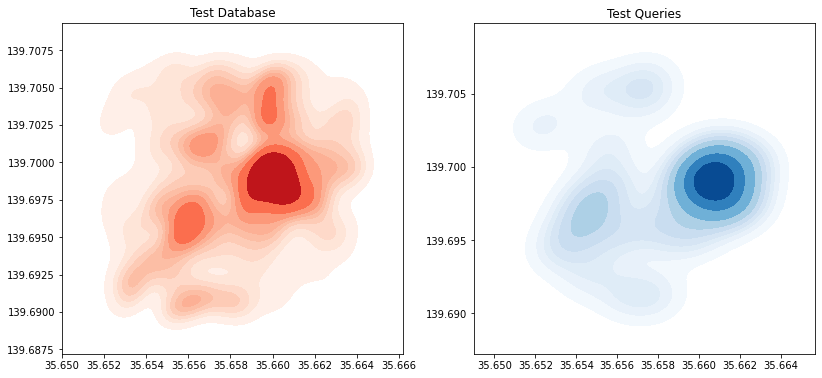

In [ ]:
#Print the density for the tokyo dataset
labels_density("tokyo")

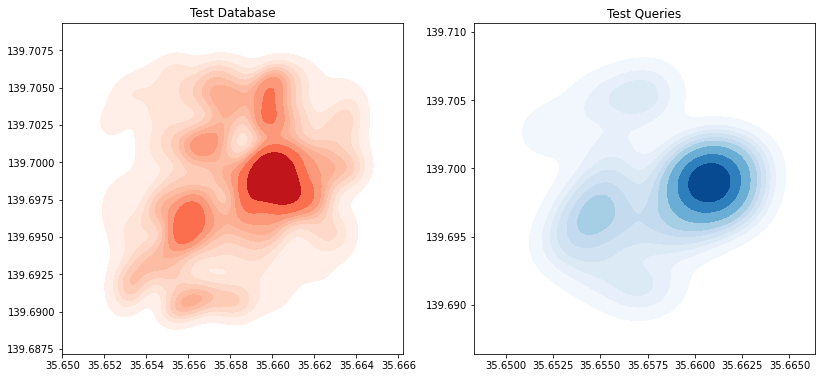

In [ ]:
#Print the density for the tokyo-night dataset
labels_density("tokyo-night")

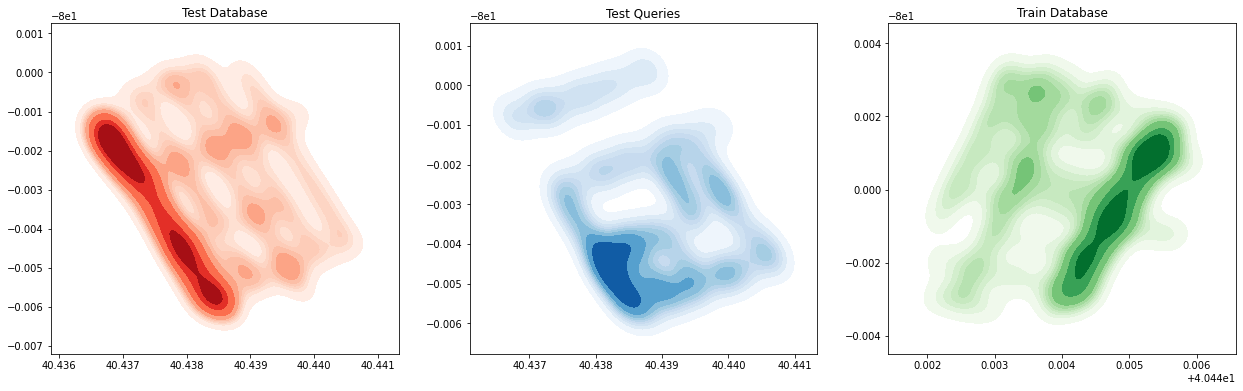

In [ ]:
#Print the density for the pitts30k dataset
labels_density("pitts30k")

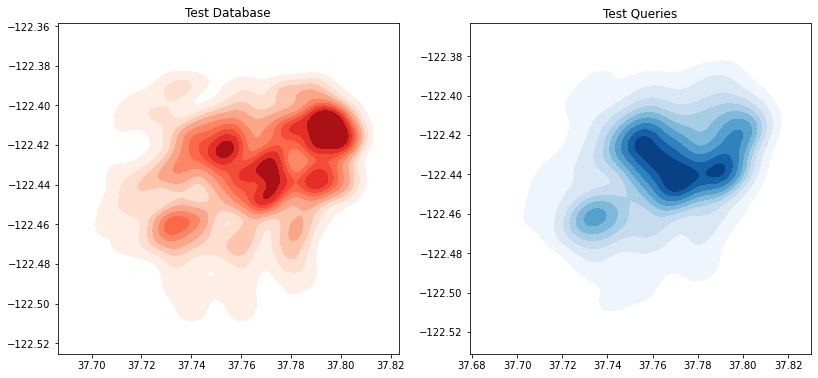

In [ ]:
#Print the density for the sf-xs dataset
labels_density("sf-xs")

#***3. “Smart” Data Augmentation for Night Domain***



In order to increase robustness to the night domain, we perform a data augmentation expertiment over the training dataset pitts30k, trying to create a set of images as similar as possible to a night-taken one.

First of all, to enable our code to perform the data augmentation, it is required to fix the following parameter in the training run:



```
--night_data_augmentation = True
```



Once enabled the function, it is possible to pass two additional parameters:


```
--solarize = float
--adjust_brightness = float
```



Default values are:
- solarize = 0.25 
- adjust_brightness = 0.55

Values must $\in$ [0,1]\
**[both parameters are required if any is changed]**

In [ ]:
!python3 train.py --dataset_name=pitts30k --aggregation=netvlad --night_data_augmentation=True --solarize=.25 --adjust_brightness=.55

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo-night

#***4. Synthetic Images as Data Augmentation***

Since the baseline model is not robust to the night domain we propose to create a new dataset that contains only night images to train the model.
First of all though we visualize one or more images found in pitts30k dataset. This is just to have a general idea of what kind of pictures we could have. 

In [ ]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k/images/train/database/*.jpg'):
  im=Image.open(filename)
  image_list.append(im) 

In [ ]:
image_list[50]
#image_list[100]
#image_list[200]
#image_list[300]
#image_list[400]
#image_list[500]

##4.1 Testing various UNIT transformations

The "UNIT PT models" folder contains all the pretrained models found in the github folder https://github.com/solesensei/day2night. All these models generate a synthetic night image starting from a day image (or vice versa based on the parameter a2b). We tested all these models to see which one would work best on the pitts30k dataset. To see which one gives us the most realistic results we used some sample images from the pitts30k dataset and transformed them to night domain. The best result obtained will later be used to transform to night domain the entire pitts30k dataset.

WARNING: every model in the github folder we mentioned that uses a VGG network does not work as presented in the github folder because it uses a funcion called vgg_lua that is no longer supported in pytorch. To use those pre-trained models we had to convert the vgg16.t7 model to a vgg16.py and vgg16.pth model. The details of this process are explained in synthetic_images/Lua2Pytorch/Lua2Pytorch.ipynb.
From this point forward we will use the UNIT models with the converted vgg16.pth and vgg16.py.

To test the UNIT models we need to move to the synthetic_images/UNIT folder and use the test_original.py provided in the github folder mentioned above.
Here we chose one particular image taken from the pitts30k dataset but the same experiment can be performed with any image. 
The translated images are visible in the synthetic_images/UNIT/results folder

In [ ]:
%cd /content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT

In [ ]:
# MUNIT_VGG
!python test_original.py --trainer=MUNIT --config="UNIT PT models/MUNIT_VGG/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/munit_vgg --checkpoint="UNIT PT models/MUNIT_VGG/gen_01000000.pt" 

In [ ]:
#UNIT
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_bis --checkpoint="UNIT PT models/UNIT/gen_00388000.pt" --a2b=1

In [ ]:
# UNIT (instance)
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT (instance)/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_instance_bis --checkpoint="UNIT PT models/UNIT (instance)/gen_00799000.pt" --a2b=1

In [ ]:
# UNIT (layer norm)
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT (layer norm)/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_layernorm_bis --checkpoint="UNIT PT models/UNIT (layer norm)/gen_00470000.pt" --a2b=1

In [ ]:
# UNIT_512x288
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_512x288/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_512x288_1bis --checkpoint="UNIT PT models/UNIT_512x288/gen_00353000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_512x288/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_512x288_2bis --checkpoint="UNIT PT models/UNIT_512x288/gen_00525000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_512x288/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_512x288_3bis --checkpoint="UNIT PT models/UNIT_512x288/gen_00822000.pt" --a2b=1

In [ ]:
# UNIT_512x288_VGG      best model found
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_512x288_VGG/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_512x288_VGG_1 --checkpoint="UNIT PT models/UNIT_512x288_VGG/gen_00256000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_512x288_VGG/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_512x288_VGG_2 --checkpoint="UNIT PT models/UNIT_512x288_VGG/gen_00473000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_512x288_VGG/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_512x288_VGG_3 --checkpoint="UNIT PT models/UNIT_512x288_VGG/gen_00716000.pt" --a2b=1

In [ ]:
# UNIT_BDD_NEXET
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_bis --checkpoint="UNIT PT models/UNIT_BDD_NEXET/gen_00762000.pt" --a2b=1

In [ ]:
# UNIT_BDD_NEXET_VGG
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG/gen_01000000.pt" --a2b=1

In [ ]:
# UNIT_BDD_NEXET_VGG_IN
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_IN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_IN_1 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_IN/gen_00351000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_IN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_IN_2 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_IN/gen_00351000.pt" --a2b=1

In [ ]:
# UNIT_BDD_NEXET_VGG_LN
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_LN_1 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/gen_00175000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_LN_2 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/gen_00230000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_LN_3 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/gen_00340000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_LN_4 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/gen_00410000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_LN_5 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/gen_00510000.pt" --a2b=1
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_BDD_NEXET_VGG_LN_6 --checkpoint="UNIT PT models/UNIT_BDD_NEXET_VGG_LN/gen_00630000.pt" --a2b=1

In [ ]:
# UNIT_VGG
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_VGG/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_VGG --checkpoint="UNIT PT models/UNIT_VGG/gen_01000000.pt" --a2b=1

In [ ]:
# UNIT_VGG (batch norm)
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_VGG (batch norm)/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_VGG_batchnorm --checkpoint="UNIT PT models/UNIT_VGG (batch norm)/gen_01000000.pt" --a2b=1

In [ ]:
# UNIT_VGG (instance norm)
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_VGG (instance norm)/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_VGG_instancenorm --checkpoint="UNIT PT models/UNIT_VGG (instance norm)/gen_00759000.pt" --a2b=1

In [ ]:
# UNIT_VGG (layer norm) 128px
!python test_original.py --trainer=UNIT --config="UNIT PT models/UNIT_VGG (layer norm) 128px/config.yaml" --input="pitts30k/images/train/database/@0584529.19@4477514.65@17@T@040.44398@-080.00325@003258@35@@@@@@pitch2_yaw12@.jpg" --output_folder=results/unit_VGG_layernorm_128px --checkpoint="UNIT PT models/UNIT_VGG (layer norm) 128px/gen_01000000.pt" --a2b=1

## 4.2 Comparing results obtained with UNIT PT models

With the help of this comparison we chose the model that created the most realistic night image starting from the input day image. We chose the UNIT_512x288_VGG model. The images shown here are simply obtained by creating collages from the images generated in the section above.

In [ ]:
import matplotlib.pyplot as plt
munit_collage=plt.imread('/content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT/results/munit_collage.png')
unit_collage=plt.imread('/content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT/results/unit_collage.jpg')

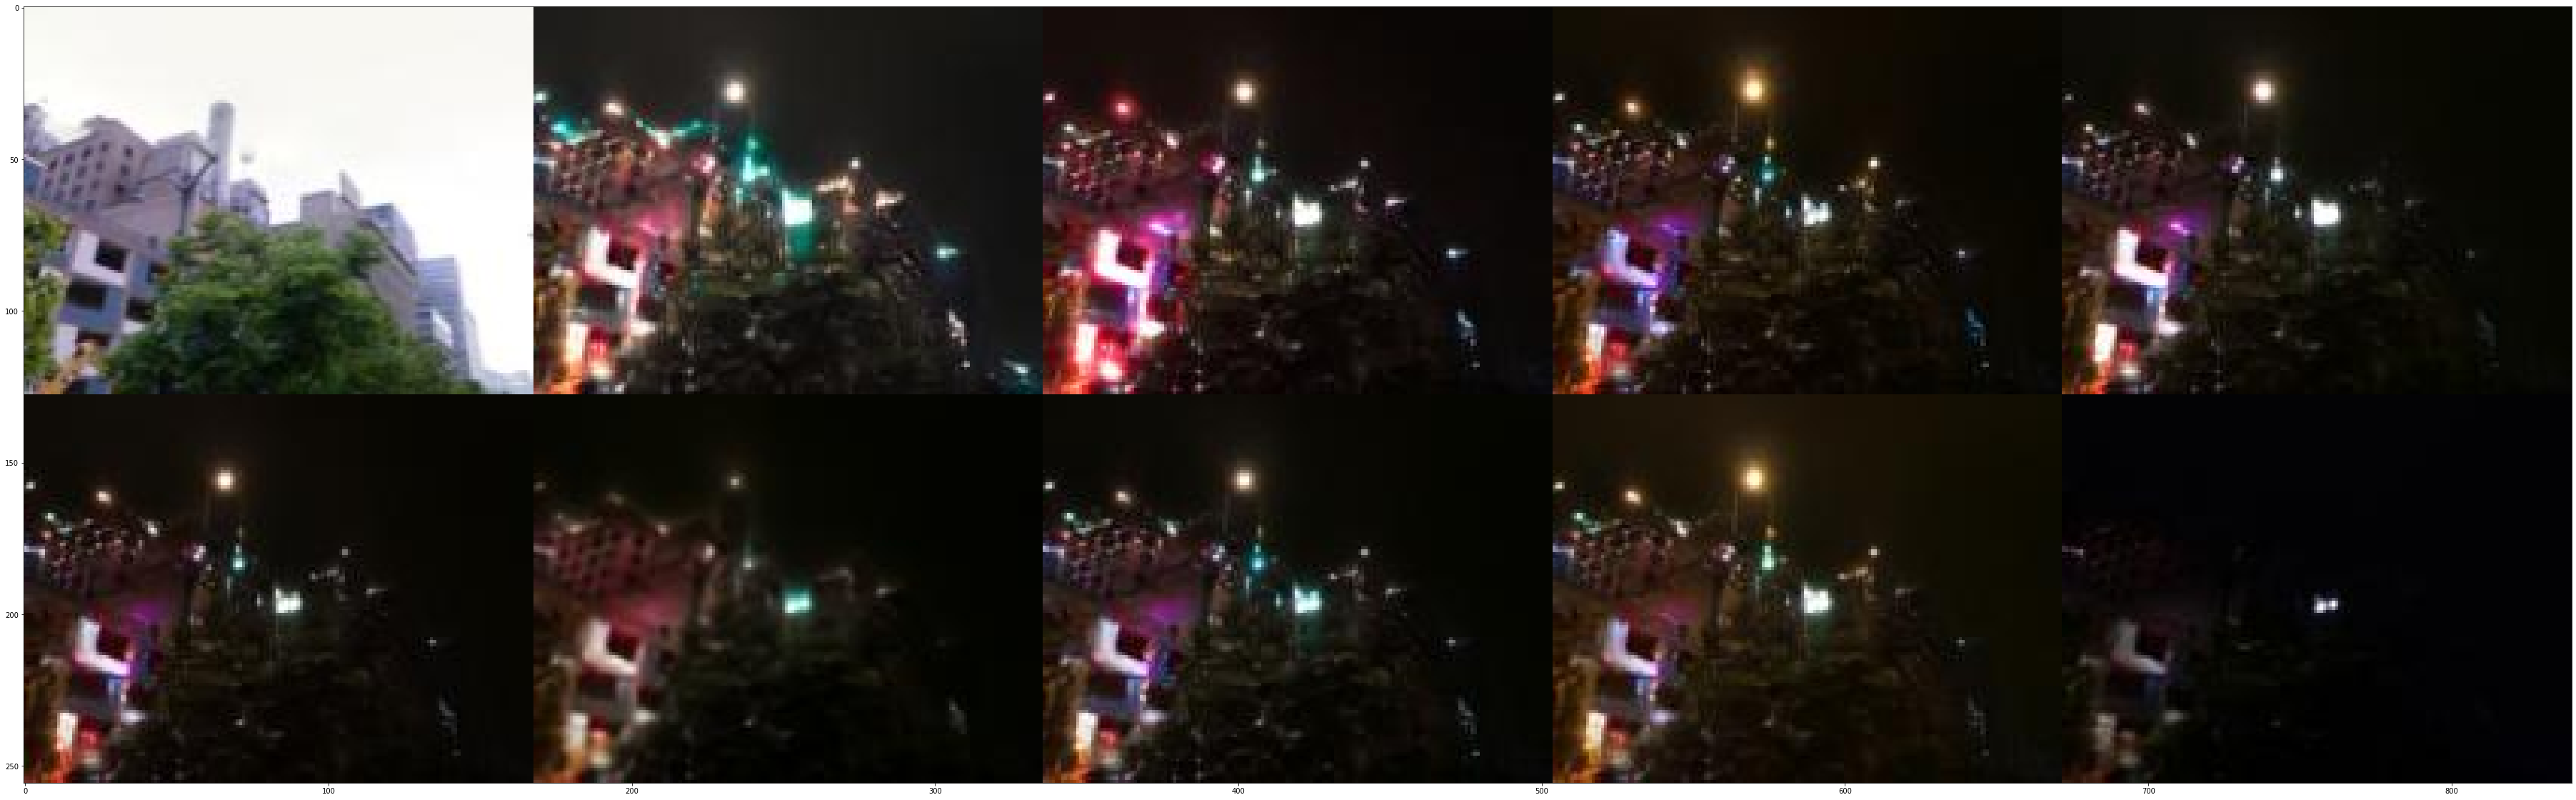

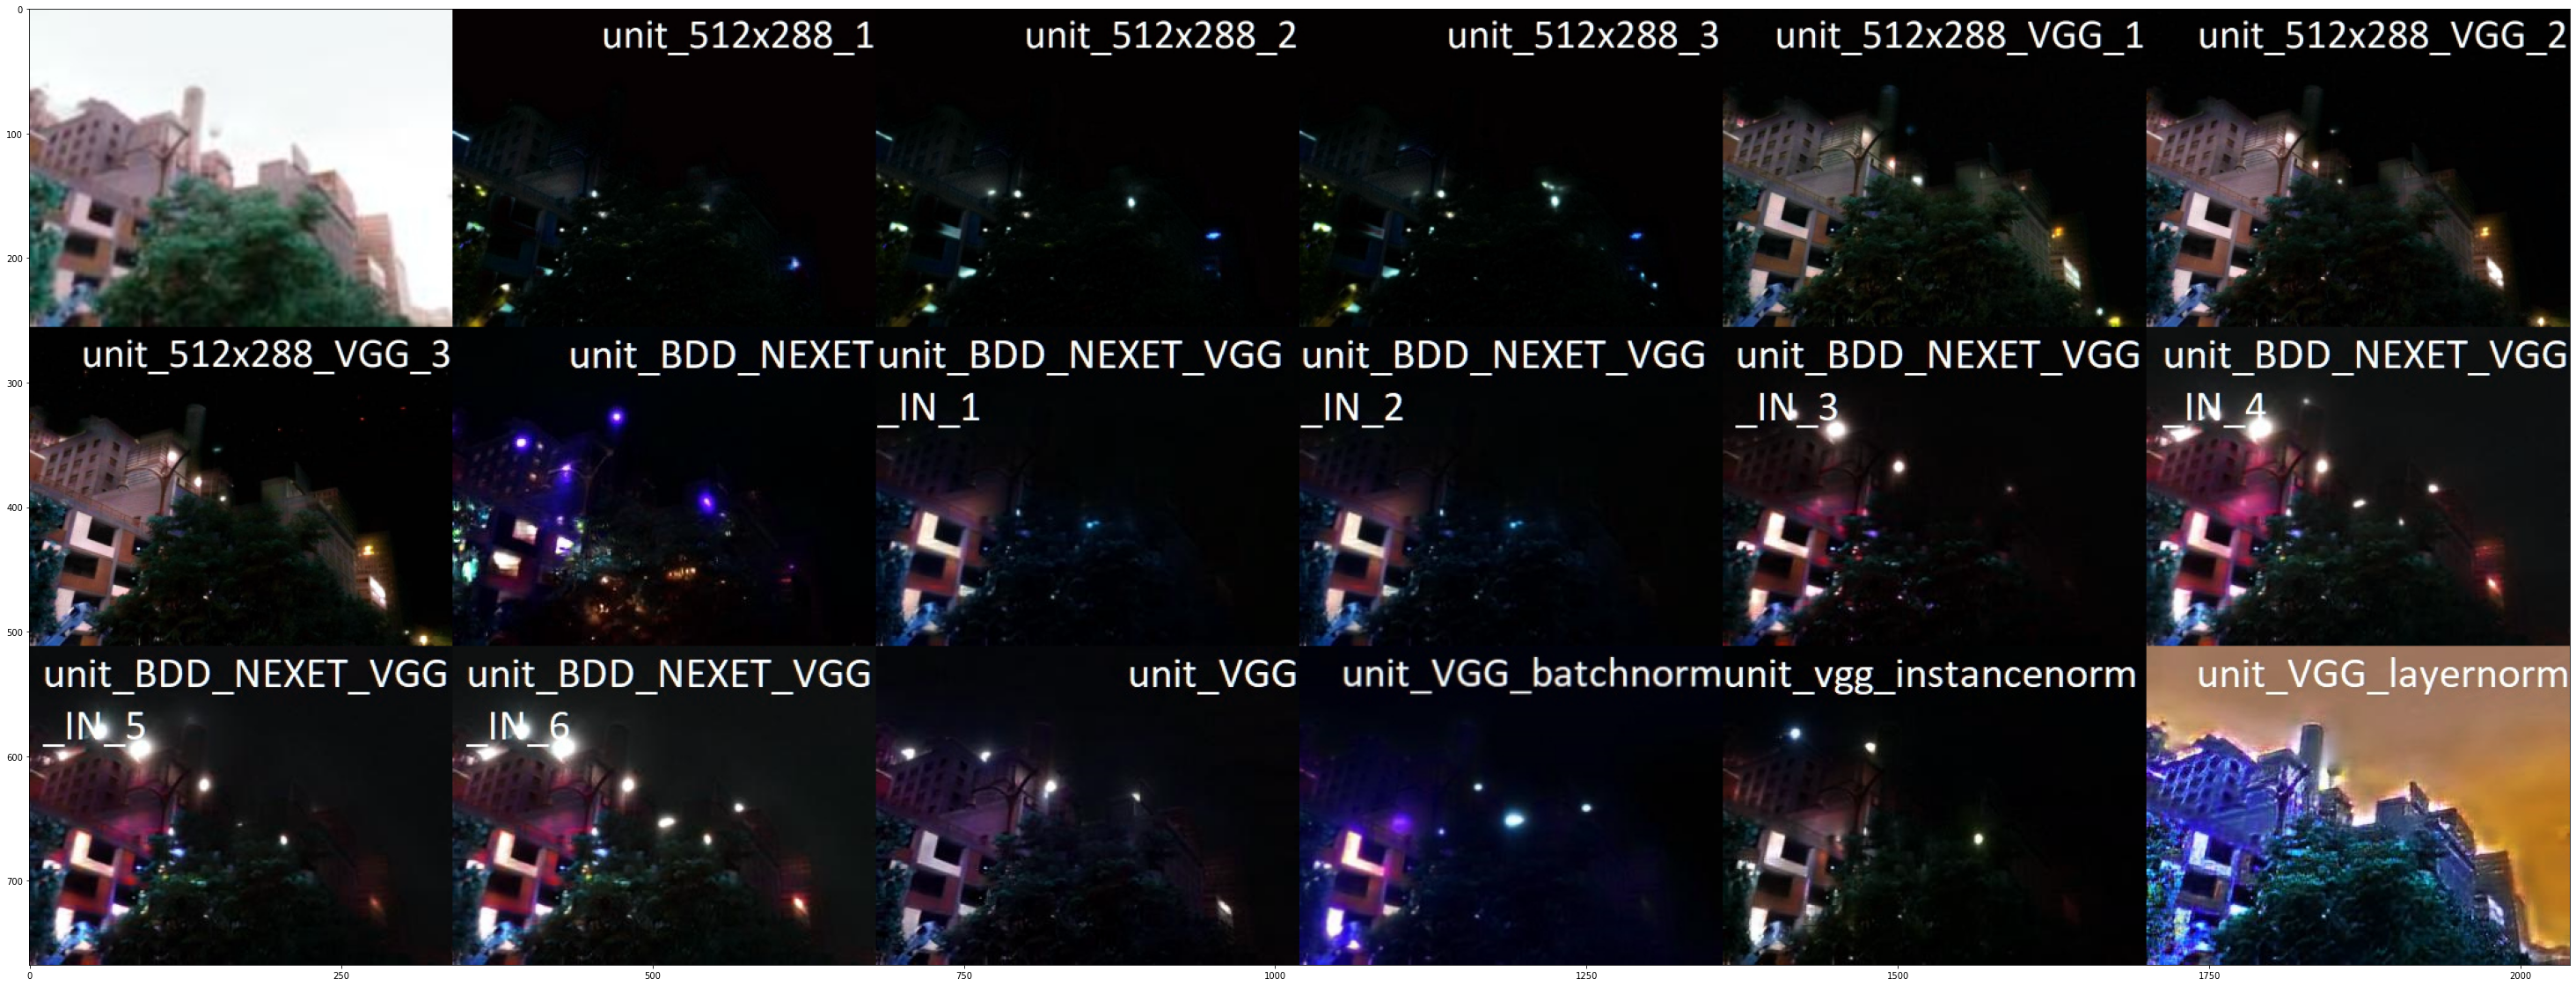

In [ ]:
plt.figure(figsize = (100,20))
plt.imshow(munit_collage)
plt.figure(figsize = (100,20))
plt.imshow(unit_collage)

## 4.3 Creation of pitts30k_night dataset

We convert the train/database and train/queries folders of pitts30k to night. The pitts30k_night dataset contains the train folder which only has night images and the val and test folder are left unchanged with respect to the original pitts30k dataset.

To create this dataset we edited the test_original.py and created test_mine.py which is equipped to convert entire folders and not just one image. This works if the --input_image parameter is set to 'no' and an --input_folder is given.

In [ ]:
!python test_mine.py --trainer=UNIT --input_image="no" --input_folder="/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k/images/train/database/" --config="/content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT/UNIT PT models/UNIT_512x288_VGG/config.yaml" --output_folder="/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_night/images/train/database" --checkpoint="/content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT/UNIT PT models/UNIT_512x288_VGG/gen_00256000.pt" --a2b=1

In [ ]:
!python test_mine.py --trainer=UNIT --input_image="no" --input_folder="/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k/images/train/queries/" --config="/content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT/UNIT PT models/UNIT_512x288_VGG/config.yaml" --output_folder="/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_night/images/train/queries" --checkpoint="/content/drive/MyDrive/code/benchmarking_vg/synthetic_images/UNIT/UNIT PT models/UNIT_512x288_VGG/gen_00256000.pt" --a2b=1

## 4.4 Creation of pitts30k_dn dataset

We need to create a dataset (for the training) that contains both the day and night images. To do this we merge the original pitts30k dataset with the previously generated pitts30k_night dataset.
To recap:
- the final pitts30k_dn/train/database contains all the pictures in pitts30k/train/database + all the pictures in pitts30k_night/train/database.
- the final pitts30k_dn/train/queries contains all the pictures in pitts30k/train/queries + all the pictures in pitts30k_night/train/queries.
- val and test folders are the same ones found in pitts30k 


In [ ]:
def copyFilesF2F(source_folder, destination_folder): #function to copy all files from a folder to another
  import os
  import glob
  import shutil

  files = []
  for filepath in glob.glob(source_folder+"*.jpg"):
    files.append(filepath)
  
  names = []
  for el in files:
    names.append(os.path.basename(el))
  
  for filename in names:
    source = source_folder+filename
    destination = destination_folder+filename
    shutil.copy(source,destination)

In [ ]:
def numImagesF(folder_path):  #number of images in a folder
  import glob
  files = []
  for filepath in glob.glob(folder_path+"*.jpg"):
    files.append(filepath)
  print("The folder has " + str(len(files)) + " pictures")

In [ ]:
#copy files from pitts30k/images/train/database to
#                pitts30k_dn/images/train/database
src = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k/images/train/database/'
dst = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_dn/images/train/database/'
copyFilesF2F(src,dst)

In [ ]:
#copy files from pitts30k_night/images/train/database to
#                pitts30k_dn/images/train/database
src = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_night/images/train/database/'
dst = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_dn/images/train/database/'
copyFilesF2F(src,dst)


In [ ]:
#copy files from pitts30k/images/train/queries to
#                pitts30k_dn/images/train/queries
src = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k/images/train/queries/'
dst = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_dn/images/train/queries/'
copyFilesF2F(src,dst)

In [ ]:
#copy files from pitts30k_night/images/train/queries to
#                pitts30k_dn/images/train/queries
src = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_night/images/train/queries/'
dst = '/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_dn/images/train/queries/'
copyFilesF2F(src,dst)

In [ ]:
#check if all the files have been copied correctly. 
#The train folders of pitts30k and pitts30k_night have 10010 pictures, the pitts30k_dn should have 20022
#The queries folders have 7417 pictures so the pitts30k_dn should have 14834
numImagesF('/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_dn/images/train/database/')
numImagesF('/content/drive/MyDrive/code/datasets_vg/datasets/pitts30k_dn/images/train/queries/')

The folder has 20020 pictures
The folder has 14832 pictures


#***5. Data Augmentation for Occlusion and Perspective Changes***

In order to increase robustness to occlusions and perspective changes, we perform some data augmentation expertiments over the training dataset pitts30.

First of all, to enable our code to perform the data augmentation, it is required to fix the following parameter in the training run:


```
--perspective_fill_data_augmentation = True

  or

--perspective_crop_data_augmentation = True

  and/or

--occlusion_data_augmentation = True
```

1. The first one performs a perspective change where the external padding of pixel value (fill) is customizable. 
2. The second one crops the perspective changed image taking only the central part of it. Height and Width are customizable. If they are greater then image dimension, a padding will be added.
3. The third one adds random occlusions to the picture.


Once enabled the functions, it is possible to pass some additional parameters:



```
--perspective_prob = float   [probability to perform the perspective change]
--occlusion_prob = float     [probability to add the random occlusion]
--distortion_scale = float   [distortion scale of the image]
--perspective_fill = float   [fill value]
--height_crop = int          [height value]
--width_crop = int           [width value]
```



Values must $\in$ [0,1], exeption made for the height and width

**[all parameters are required if any is changed]**

In [ ]:
!python3 train.py --dataset_name=pitts30k --aggregation=netvlad --occlusion_data_augmentation=True

In [ ]:
!python3 train.py --dataset_name=pitts30k --aggregation=netvlad --perspective_crop_data_augmentation=True

#***6. Ensembles***

To improve the recalls we tried to concatenate the descriptors obtained with different models.We have
performed two experiments: simple addition of descriptors obtained
from different models (AlexNet + ResNet18 + Aggregation
layer), and division model descriptors. 
Ensembling two different backbones and then merging obtained results to feed the aggregation layer. In order to work with this extension we added 2 more arguments to the original parser.py file with the arguments, specifically we fixed two backbones (Alexnet and Resnet) in order to ensemble their descriptors.

## 6.1 Important packages for Ensemble learning extension.

In [ ]:
%cd benchmarking_vg
!pip install --upgrade torch==1.9.0
!pip install --upgrade torchvision==0.10.0

##6.2 Testing tensor division with NetVlad aggregation layer.

First we perform tensor division by 2, which is exactly feature map computed from two different backbones (AlexNet and ResNet18), we add them and divide features by two, because at the end we want to get average feature values for aggregation layer.To do this replace the generic log folder with the trained model you wish. (log folder: YYYY-MM-DD_HH-MM-SS - for example:2022-07-11_06-12-02)


In [ ]:
!python3 train_ensemble.py --dataset_name=pitts30k --aggregation=netvlad --epochs=2

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo-night

##6.2.1 Testing tensor division with GEM aggregation layer.


In [ ]:
!python3 train_ensemble.py --dataset_name=pitts30k --aggregation=gem --epochs=2

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs --aggregation=gem

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo --aggregation=gem

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo-night --aggregation=gem

##6.2.2 Testing tensor division with MAC aggregation layer.


In [ ]:
!python3 train_ensemble.py --dataset_name=pitts30k --aggregation=mac --epochs=2

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo-night --aggregation=mac

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo --aggregation=mac

In [ ]:
!python3 eval_ensemble.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs --aggregation=mac

##6.3 Testing tensor addition with MAC aggregation layer.
Tensor addition from different models was performed in order to undersatand and see if simple operations on tensors can improve the performance, so that we obtain more meaningful values on final feature map.


In [ ]:
!python3 train_ensemble_addition.py --dataset_name=pitts30k --aggregation=mac --epochs=2

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo-night --aggregation=mac

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo --aggregation=mac

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs --aggregation=mac

##6.3.1 Testing tensor addition with GEM aggregation layer.


In [ ]:
!python3 train_ensemble_addition.py --dataset_name=pitts30k --aggregation=gem --epochs=2

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo-night --aggregation=gem

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo --aggregation=gem

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs --aggregation=gem

##6.3.2 Testing tensor addition with NetVLAD aggregation layer.

In [ ]:
!python3 train_ensemble_addition.py --dataset_name=pitts30k --aggregation=netvlad --epochs=2

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=sf-xs 

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/YYYY-MM-DD_HH-MM-SS/best_model.pth --dataset_name=tokyo

In [ ]:
!python3 eval_ensemble_addition.py --resume=logs/default/2022-07-09_22-15-12/best_model.pth --dataset_name=tokyo-night

#***7. Multi-scale Testing***

In this section we perform the multiscale testing using both the concatenation and the average methods. To perform this task three arguments have been added to the original parser creating the file parser_multiscale.py:

--multiscale: if this argument is set to true then the multiscale testing is performed, otherwise it's ignored. Default value is "False".

--step_multiscale: this argument contains the vector that defines how much the dimension of the images will be reduced. The default vector is [2,3,4] which means that the dimension of the images will be reduced to a half, then a third and the a fourth and all the descriptors obtained will either be concatenated or averaged based on the next parameter.

--multiscale_method: this argument should contain a string that is either 'concat' or 'average' and based on this string the multiscale testing will be performed either concatenating all the descriptors or averaging them.

To perform this task the test.py file has been modified and we now use the test_multiscale.py which contains the code to resize the image and concatenate or average the descriptors. The eval file is basically the same but uses the functions defined in test_multiscale.py so we created a new file called eval_multiscale.py. The train files and the datasets_ws files are left untouched.

NB: We use the same trained models obtained before while training with netvlad and gem and using the original Pitts30k dataset.

## 7.1 Concatenation
First of all we perform the concatenation of the descriptors testing with NetVLAD. To do this replace the generic log folder with the trained model you wish.

Testing concatenation with NetVLAD

In [ ]:
#test on pitts30k with netvlad, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=pitts30k --multiscale=True --multiscale_method=concat

In [ ]:
#test on sf-xs with netvlad, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=sf-xs --multiscale=True --multiscale_method=concat

In [ ]:
#test on tokyo with netvlad, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo --multiscale=True --multiscale_method=concat

In [ ]:
#test on tokyo-night with netvlad, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo-night --multiscale=True --multiscale_method=concat

Testing concatenation with GeM

In [ ]:
#test on pitts30k with gem, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=pitts30k --multiscale=True --multiscale_method=concat --aggregation=gem

In [ ]:
#test on sf-xs with gem, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=sf-xs --multiscale=True --multiscale_method=concat --aggregation=gem

In [ ]:
#test on tokyo with gem, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo --multiscale=True --multiscale_method=concat --aggregation=gem

In [ ]:
#test on tokyo-night with gem, concat and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo-night --multiscale=True --multiscale_method=concat --aggregation=gem

## 7.2 Average

A true average can not be performed since the number of features extracted from images of different dimensions are different!
So we can't simply perform the sum of features from the original image with the features obtained from the image resized because the dimensions of the tensors don't match.
So in an attempt to perform some sort of average descriptors the following procedure has been applied:
1. The orignal image is encoded and it's features are exctracted. The dimension of the tensor that contains these features is [16,256,1200].
2. The image is then reiszed based on the values given in the vector step_multiscale. The features extracted from this vector are of dimensions [16,256,x] where x depends on the current step.
3. To make the resized image compatible with the original (in terms of features tensors) we use the torch.repeat method which allows us to repeat a tensor along the chosen dimension. Basically we leave as they are the first two dimensions and we repeat the tensor along the last dimension. We repeat the tensor a number of times that is equal to step^2.
4. Since the dimensions obtained this way could lead to a features tensor slightly longer that the original features vector we consider only the first 1200 entries along the last dimension:

features = features + features_resized.repeat(1,1,step**2)[ : , : , : 1200]

This is a naive approach and can definitely be improved as a future work.

Testing average with NetVLAD

In [ ]:
#test on pitts30k with netvlad, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=pitts30k --multiscale=True --multiscale_method='average'

In [ ]:
#test on sf-xs with netvlad, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=sf-xs --multiscale=True --multiscale_method='average'

In [ ]:
#test on tokyo with netvlad, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo --multiscale=True --multiscale_method='average'

In [ ]:
#test on tokyo-night with netvlad, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo-night --multiscale=True --multiscale_method='average'

Testing average with GeM

In [ ]:
#test on pitts30k with gem, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=pitts30k --multiscale=True --multiscale_method=average --aggregation=gem

In [ ]:
#test on pitts30k with gem, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=sf-xs --multiscale=True --multiscale_method=average --aggregation=gem

In [ ]:
#test on pitts30k with gem, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo --multiscale=True --multiscale_method=average --aggregation=gem

In [ ]:
#test on pitts30k with gem, average and the default step_multiscale=[2,3,4]
!python3 eval_multiscale.py --resume=logs/default/'YYYY-MM-DD_hh-mm-ss'/best_model.pth --dataset_name=tokyo-night --multiscale=True --multiscale_method=average --aggregation=gem